# Maestría en Inteligencia Artificial Aplicada

## ****Proyecto Integrador: Sistema de visión computacional para normalización y validación visual de anaqueles fríos****

### Tecnológico de Monterrey


## Adtividad de las Semanas 4
### **Avance 2. Ingeniería de características**


#### **Nombre de estudiantes:**

**Carlos Eduardo Ramírez Vázquez** Matrícula: A01795468

**Cesar Bryam Rodriguez Aybar**    Matrícula: A01795980

**Wilberth Eduardo López Gómez**   Matrícula: A01795997





In [ ]:
import cv2, json, random, os, math
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from collections import Counter
from copy import deepcopy
from dataclasses import dataclass
from typing import Any, Dict, List, Tuple, Optional

data_path = "/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/"

# 1. Objetivo técnico del proyecto

Dada una imagen cruda de anaquel:

1.   Se aplica un preproceso determinista (**unfisheye**) para obtener una imagen en un espacio base
2.   A partir de esta imagen base, un **modelo** de visión por computadora **predice** los vértices de las puertas (**keypoints**)
3.   Con esos vértices se calcula una **homografía** para rectificar la imagen

El resultado final del proyecto es producir una configuración en formato JSON que permita reproducir la rectificación siguiendo el estilo del JSON de referencia que se muestra a continuación.

In [ ]:
# JSON que se usa actualmente para rectificar imagenes en Bnext.
# Este JSON lo generan manualmente por medio de una webapp

output_ejemplo = {
    "rotate": {
        "enabled": True,
        "rotation_angle": -2.0
    },
    "warp": {
        "enabled": True,
        "top_warp": 0,
        "bottom_warp": 878
    },
"unfisheye": {
        "enabled": False,
        "focal_length": 7000.0,
        "k1": -2.0,
  "k2": 100.0
    },
    "crop": {
        "enabled": True,
        "bbox": [
            68,
            314,
            3404,
            1823
        ]
    },
    "type": {
        "enabled": False,
        "detection_type": "refrigerador" # vitrina o refrigerador
    }
}

# 2. Contratos

Para lograr el objetivo del proyecto, necesitamos hacer esta fase de preparación de datos y feature engineering.

Primero, vamos a definir los contratos de input y outputs que necesitaremos para esta y otras fases (como la de modelado).

In [ ]:
Point = Tuple[float, float]  # (x, y) en pixeles o normalizado - se especifica por campo
Quad = List[Point]           # 4 puntos

# =========================
# 1) Schema de anotaciones (ground truth)
# =========================
# Las puertas tienen 4 vértices en sentido horario, empezando en top-left: [TL, TR, BR, BL].
# Estos vértices se anotarán manualmente para construir el ground truth que usaremos en fases posteriores

ANNOTATION_SCHEMA_EXAMPLE: Dict[str, Any] = {
    "image_id": "img_0001",
    "image_path": "raw_data/img_0001.jpg",
    "width": 1920,
    "height": 1080,
    "coordinate_space": "pixel",  # "pixel" o "normalized"
    "doors": [
        {
            "door_id": 1,
            "vertices": [[100, 200], [400, 210], [395, 900], [110, 890]],  # TL,TR,BR,BL (En sentido horario)
            "is_valid": True
        }
    ]
}

# =========================
# 2) Schema de predicción (output del modelo)
# =========================
# Misma estructura conceptual que el ground truth, pero producido por el modelo
PREDICTION_SCHEMA_EXAMPLE: Dict[str, Any] = {
    "image_id": "img_0001",
    "coordinate_space": "normalized",
    "doors": [
        {
            "door_id": 1,
            "vertices": [[0.05, 0.18], [0.22, 0.19], [0.21, 0.83], [0.06, 0.82]]
        }
    ]
}

# =========================
# 3) Schema de configuración final (target)
# =========================
# Similar al JSON de ejemplo de Bnext
TARGET_CONFIG_SCHEMA_EXAMPLE: Dict[str, Any] = {
    "unfisheye": {
        "enabled": True,
        # Referencia a parámetros deterministas del sistema (K/D fijos o fuerza/zoom fijados internamente).
        "profile_id": "global_v1"
    },
    "warp": {
        "enabled": True,
        # Guardamos la homografía explícita (lo podemos obtener determinísticamente desde vértices)
        "homography_3x3": [
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, 1.0]
        ]
    },
    "rotate": {
        "enabled": False,
        "rotation_angle": 0.0
    },
    "crop": {
        "enabled": False,
        "bbox": [0, 0, 0, 0]  # left, top, right, bottom
    },
    "type": {
        "enabled": True,
        "detection_type": "refrigerador"  # o "vitrina"
    }
}



Estas validaciones son las que asegurarán nuestro dataset y las salidas del modelo.

In [ ]:
def assert_has_keys(d: Dict[str, Any], keys: List[str], name: str = "dict") -> None:
    missing = [k for k in keys if k not in d]
    assert not missing, f"{name} missing keys: {missing}"

def assert_vertices_shape(vertices: Any) -> None:
    assert isinstance(vertices, list), "vertices must be a list"
    assert len(vertices) == 4, f"vertices must have 4 points, got {len(vertices)}"
    for p in vertices:
        assert isinstance(p, (list, tuple)) and len(p) == 2, f"point must be [x,y], got {p}"
        x, y = p
        assert isinstance(x, (int, float)) and isinstance(y, (int, float)), f"x,y must be numeric, got {p}"

def polygon_signed_area(pts: Quad) -> float:
    # Shoelace (área con signo). Ojo: en coordenadas de imagen (y hacia abajo),
    # el signo se invierte vs cartesiano clásico.
    area = 0.0
    for i in range(len(pts)):
        x1, y1 = pts[i]
        x2, y2 = pts[(i + 1) % len(pts)]
        area += (x1 * y2) - (x2 * y1)
    return area / 2.0

def is_clockwise(pts: Quad) -> bool:
    # En coordenadas de imagen (y hacia abajo), CW suele dar área > 0.
    return polygon_signed_area(pts) > 0

def assert_clockwise(pts: Quad) -> None:
    assert is_clockwise(pts), "vertices are not in clockwise order (image coords)"

def assert_top_left_first(pts: Quad) -> None:
    # Top-left aproximado: menor y; en empate, menor x.
    # Esto es una regla simple; no “ordena”, solo valida el contrato.
    ys = [p[1] for p in pts]
    min_y = min(ys)
    candidates = [p for p in pts if abs(p[1] - min_y) < 1e-9]
    tl = min(candidates, key=lambda p: p[0])

    first = pts[0]
    assert abs(first[0] - tl[0]) < 1e-6 and abs(first[1] - tl[1]) < 1e-6, (
        f"first vertex is not top-left. expected {tl}, got {first}"
    )

def assert_coordinate_space(coord_space: str) -> None:
    assert coord_space in ("pixel", "normalized"), f"coordinate_space must be 'pixel' or 'normalized', got {coord_space}"

def assert_points_in_range(vertices: Quad, coord_space: str, width: int, height: int) -> None:
    if coord_space == "normalized":
        for x, y in vertices:
            assert 0.0 <= x <= 1.0 and 0.0 <= y <= 1.0, f"normalized point out of range: {(x,y)}"
    else:
        for x, y in vertices:
            assert 0.0 <= x <= width and 0.0 <= y <= height, f"pixel point out of range: {(x,y)}"

def assert_annotation_record(rec: Dict[str, Any]) -> None:
    assert_has_keys(rec, ["image_id", "image_path", "width", "height", "coordinate_space", "doors"], name="annotation")
    assert isinstance(rec["doors"], list), "doors must be a list"
    assert_coordinate_space(rec["coordinate_space"])
    w, h = int(rec["width"]), int(rec["height"])
    assert w > 0 and h > 0, "width/height must be positive"

    for door in rec["doors"]:
        assert_has_keys(door, ["door_id", "vertices"], name="door")
        assert_vertices_shape(door["vertices"])
        pts = [(float(x), float(y)) for x, y in door["vertices"]]
        assert_points_in_range(pts, rec["coordinate_space"], w, h)
        # contrato geométrico:
        assert_clockwise(pts)
        assert_top_left_first(pts)

def assert_prediction_record(rec: Dict[str, Any]) -> None:
    assert_has_keys(rec, ["image_id", "coordinate_space", "doors"], name="prediction")
    assert_coordinate_space(rec["coordinate_space"])
    assert isinstance(rec["doors"], list), "doors must be a list"
    for door in rec["doors"]:
        assert_has_keys(door, ["door_id", "vertices"], name="predicted door")
        assert_vertices_shape(door["vertices"])
        pts = [(float(x), float(y)) for x, y in door["vertices"]]
        # En predicción normalizada no tenemos width/height aquí; validamos rango 0..1 si aplica.
        if rec["coordinate_space"] == "normalized":
            for x, y in pts:
                assert 0.0 <= x <= 1.0 and 0.0 <= y <= 1.0, f"normalized point out of range: {(x,y)}"
        assert_clockwise(pts)
        assert_top_left_first(pts)

In [ ]:
# Smoke tests con los ejemplos definidos arriba
assert_annotation_record(ANNOTATION_SCHEMA_EXAMPLE)
assert_prediction_record(PREDICTION_SCHEMA_EXAMPLE)

print("✅ Contrato: OK")

✅ Contrato: OK


In [ ]:
path_imagenes = data_path + 'rawdata'

if os.path.exists(path_imagenes):
    # Listar archivos para verificar acceso
    archivos = os.listdir(path_imagenes)
    print(f"Se encontraron {len(archivos)} archivos en la carpeta.")
    print("Primeros 10 archivos:", archivos[:10])
else:
    print(f"La ruta no existe: {path_imagenes}")

Se encontraron 26 archivos en la carpeta.
Primeros 10 archivos: ['20251125151943.jpg', '20251022140230.jpg', '20251022170107.jpg', '20251023180921.jpg', '20251126143832.jpg', '20251022090039.jpg', '20251125173359.jpg', '20251023150039.jpg', '20251126115044.jpg', '20251023180801.jpg']


# 3. Datos

Cargamos las imágenes, analizamos sus propiedades (resolución, dtype, pixel range), y visualizamos algunas de ellas usando OpenCV y Matplotlib.



Archivo: 20251125151943.jpg
  Shape: (1080, 1920, 3)
  Dtype: uint8
  Pixel Range: 0 - 255
------------------------------
Archivo: 20251022140230.jpg
  Shape: (1080, 1920, 3)
  Dtype: uint8
  Pixel Range: 0 - 255
------------------------------
Archivo: 20251022170107.jpg
  Shape: (1080, 1920, 3)
  Dtype: uint8
  Pixel Range: 0 - 255
------------------------------
Archivo: 20251023180921.jpg
  Shape: (1080, 1920, 3)
  Dtype: uint8
  Pixel Range: 0 - 255
------------------------------
Archivo: 20251126143832.jpg
  Shape: (1080, 1920, 3)
  Dtype: uint8
  Pixel Range: 0 - 255
------------------------------


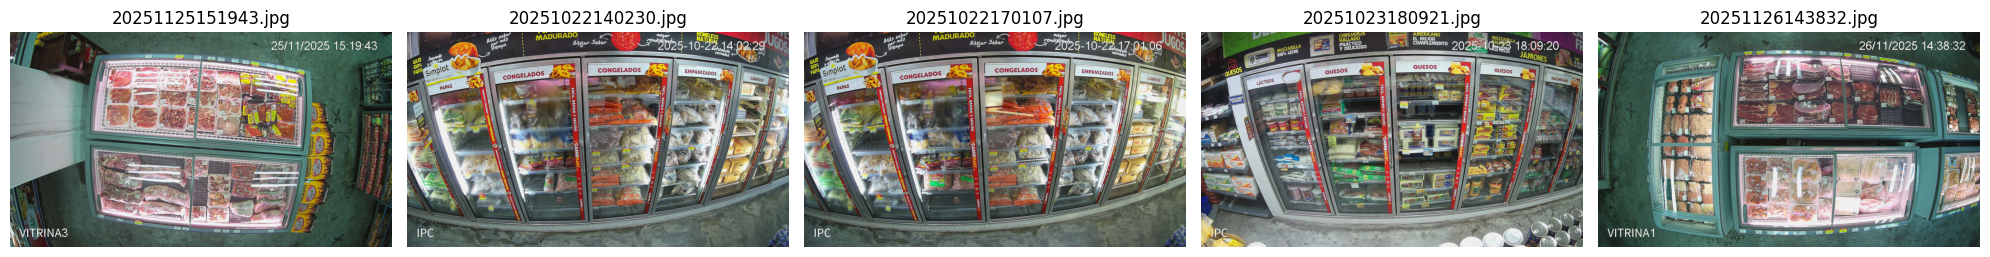

In [ ]:
# Usaremos 5 imagenes como ejemplo
sample_files = archivos[:5]

plt.figure(figsize=(20, 5))

for i, filename in enumerate(sample_files):
    img_path = os.path.join(path_imagenes, filename)

    img = cv2.imread(img_path)

    if img is not None:
        print(f"Archivo: {filename}")
        print(f"  Shape: {img.shape}")
        print(f"  Dtype: {img.dtype}")
        print(f"  Pixel Range: {img.min()} - {img.max()}")
        print("-" * 30)

        # Convert BGR to RGB for correct visualization
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Add to subplot
        plt.subplot(1, 5, i + 1)
        plt.imshow(img_rgb)
        plt.title(filename)
        plt.axis('off')
    else:
        print(f"Error: No se pudo cargar la imagen {filename}")

plt.tight_layout()
plt.show()

# 4. Preprocesamiento: Unfisheye

En esta parte, vamos a quitar el efecto de ojo de pez que tienen las imágenes.

In [ ]:
PROC_DIR = Path(data_path)
UNFISHEYE_DIR = PROC_DIR / "unfisheye_data"
UNFISHEYE_DIR.mkdir(parents=True, exist_ok=True)

# Parámetros deterministas globales (mismos para todas las cámaras)
UNFISHEYE_FUERZA = 0.2
UNFISHEYE_ZOOM = 0.6

RAW_DIR = Path(path_imagenes)

def list_images(raw_dir: Path):
    paths = []
    for p in raw_dir.rglob("*"):
        paths.append(p)
    return sorted(paths)

def build_image_index(paths):
    index = {}
    collisions = {}
    for p in paths:
        base_id = p.stem  # filename without extension
        if base_id in index:
            collisions[base_id] = collisions.get(base_id, 0) + 1
            new_id = f"{base_id}__{collisions[base_id]}"
            index[new_id] = str(p)
        else:
            index[base_id] = str(p)
    return index

raw_paths = list_images(RAW_DIR)
assert len(raw_paths) > 0, f"No images found in {RAW_DIR}"

image_index = build_image_index(raw_paths)

In [ ]:
def corregir_fisheye_completo(img, fuerza=0.2, zoom=0.6):
    """
    Corrige fisheye manteniendo toda la imagen visible

    fuerza: 0.1-0.5 (qué tanto corregir)
    zoom: 0.4-1.0 (qué tanto hacer zoom out para ver todo)
          Valores más bajos = más imagen visible pero más pequeña en el centro
    """
    h, w = img.shape[:2]

    # Matriz de cámara con zoom ajustado
    focal = w * zoom  # Reducir focal para ver más contenido
    K = np.array([[focal, 0, w / 2],
                  [0, focal, h / 2],
                  [0, 0, 1]], dtype=np.float32)

    # Coeficientes de distorsión
    D = np.array([-fuerza, fuerza/3, 0.0, 0.0], dtype=np.float32)

    # Nueva matriz de cámara para el output (con más FOV)
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(
        K, D, (w, h), np.eye(3), balance=1.0  # balance=1.0 mantiene todo visible
    )

    # Mapas de corrección
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(
        K, D, np.eye(3), new_K, (w, h), cv2.CV_16SC2
    )

    # Aplicar corrección
    img_corregida = cv2.remap(img, map1, map2,
                              interpolation=cv2.INTER_LINEAR,
                              borderMode=cv2.BORDER_CONSTANT)

    return img_corregida

In [ ]:
def apply_unfisheye_and_save(image_index, out_dir: Path, fuerza: float, zoom: float, overwrite: bool = False):
    unfisheye_index = {}

    for image_id, raw_path in tqdm(image_index.items(), desc="Aplicando UNFISHEYE"):
        raw_path = str(raw_path)
        out_path = out_dir / f"{image_id}.jpg"
        unfisheye_index[image_id] = str(out_path)

        if out_path.exists() and not overwrite:
            continue

        img_bgr = cv2.imread(raw_path, cv2.IMREAD_COLOR)
        assert img_bgr is not None, f"No se pudo leer: {raw_path}"

        img_corr = corregir_fisheye_completo(img_bgr, fuerza=fuerza, zoom=zoom)

        ok = cv2.imwrite(str(out_path), img_corr)
        assert ok, f"No se pudo escribir: {out_path}"

    return unfisheye_index

unfisheye_index = apply_unfisheye_and_save(
    image_index=image_index,
    out_dir=UNFISHEYE_DIR,
    fuerza=UNFISHEYE_FUERZA,
    zoom=UNFISHEYE_ZOOM,
    overwrite=False
)

print(f"UNFISHEYE completado. Archivos: {len(unfisheye_index)}")
print("Ejemplo:", next(iter(unfisheye_index.items())))

Aplicando UNFISHEYE: 100%|██████████| 26/26 [00:19<00:00,  1.36it/s]

UNFISHEYE completado. Archivos: 26
Ejemplo: ('20251022075804', '/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/unfisheye_data/20251022075804.jpg')


In [ ]:
def show_raw_vs_unfisheye(image_index, unfisheye_index, n=3, seed=123):
    random.seed(seed)
    keys = list(image_index.keys())
    picks = random.sample(keys, k=min(n, len(keys)))

    plt.figure(figsize=(14, 5 * len(picks)))

    for i, image_id in enumerate(picks, 1):
        raw_path = image_index[image_id]
        unf_path = unfisheye_index[image_id]

        raw_bgr = cv2.imread(str(raw_path), cv2.IMREAD_COLOR)
        unf_bgr = cv2.imread(str(unf_path), cv2.IMREAD_COLOR)

        assert raw_bgr is not None and unf_bgr is not None, f"Error leyendo {image_id}"

        raw_rgb = cv2.cvtColor(raw_bgr, cv2.COLOR_BGR2RGB)
        unf_rgb = cv2.cvtColor(unf_bgr, cv2.COLOR_BGR2RGB)

        h1, w1 = raw_rgb.shape[:2]
        h2, w2 = unf_rgb.shape[:2]

        # Raw
        plt.subplot(len(picks), 2, (i - 1) * 2 + 1)
        plt.imshow(raw_rgb)
        plt.title(f"RAW — {image_id} ({w1}x{h1})")
        plt.axis("off")

        # Unfisheye
        plt.subplot(len(picks), 2, (i - 1) * 2 + 2)
        plt.imshow(unf_rgb)
        plt.title(f"UNFISHEYE — {image_id} ({w2}x{h2})\n(fuerza={UNFISHEYE_FUERZA}, zoom={UNFISHEYE_ZOOM})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_raw_vs_unfisheye(image_index, unfisheye_index, n=3, seed=42)

Output hidden; open in https://colab.research.google.com to view.

# 5. Preprocesamiento: Normalización/Estandarización

En este paso vamos a confirmar la resolución, normalizar intensidades y dejar una función preprocess_image() que produzca las imágenes que estarán listas para la fase de modelado.

In [ ]:
def collect_shapes(index, max_check=None):
    shapes = []
    for i, (image_id, path) in enumerate(index.items()):
        if max_check is not None and i >= max_check:
            break
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        assert img is not None, f"No se pudo leer: {path}"
        h, w = img.shape[:2]
        shapes.append((w, h))
    return shapes

shapes = collect_shapes(unfisheye_index)  # índice post-unfisheye del Paso 3
counts = Counter(shapes)

print("Distribución de resoluciones (post-unfisheye):")
for (w, h), cnt in counts.most_common(10):
    print(f"- {w}x{h}: {cnt}")

# Resolución "esperada" (si todas son 1920x1080)
EXPECTED_WH = (1920, 1080)

if len(counts) == 1 and next(iter(counts.keys())) == EXPECTED_WH:
    print("✅ Todas las imágenes están en 1920x1080. No se requiere resize.")
else:
    print("⚠️ Hay más de una resolución o no coincide con 1920x1080.")
    print("   Se recomienda estandarizar a EXPECTED_WH en preprocess_image().")

Distribución de resoluciones (post-unfisheye):
- 1920x1080: 26
✅ Todas las imágenes están en 1920x1080. No se requiere resize.


In [ ]:
EXPECTED_WH = (1920, 1080)  # (Width, Height)

def preprocess_image(img_unfisheye_bgr: np.ndarray,
                     expected_wh=EXPECTED_WH,
                     force_resize: bool = False) -> np.ndarray:
    """
    Input: imagen post-unfisheye en BGR (OpenCV)
    Output: img_ready en RGB, float32, normalizada a [0,1]

    - Solo se hace resize si force_resize=True.
    """
    assert img_unfisheye_bgr is not None, "img_unfisheye_bgr is None"
    assert img_unfisheye_bgr.ndim == 3 and img_unfisheye_bgr.shape[2] == 3, "Se espera imagen BGR 3 canales"

    h, w = img_unfisheye_bgr.shape[:2]
    exp_w, exp_h = expected_wh

    if (w, h) != (exp_w, exp_h):
        if force_resize:
            img_unfisheye_bgr = cv2.resize(img_unfisheye_bgr, (exp_w, exp_h), interpolation=cv2.INTER_LINEAR)
        else:
            raise ValueError(f"Resolución inesperada {w}x{h}. Esperada {exp_w}x{exp_h}. "
                             f"Si quieres permitirlo, usa force_resize=True.")

    # BGR a RGB
    img_rgb = cv2.cvtColor(img_unfisheye_bgr, cv2.COLOR_BGR2RGB)

    # Normalización [0,255] -> [0,1] - min–max scaling
    img_ready = img_rgb.astype(np.float32) / 255.0

    return img_ready

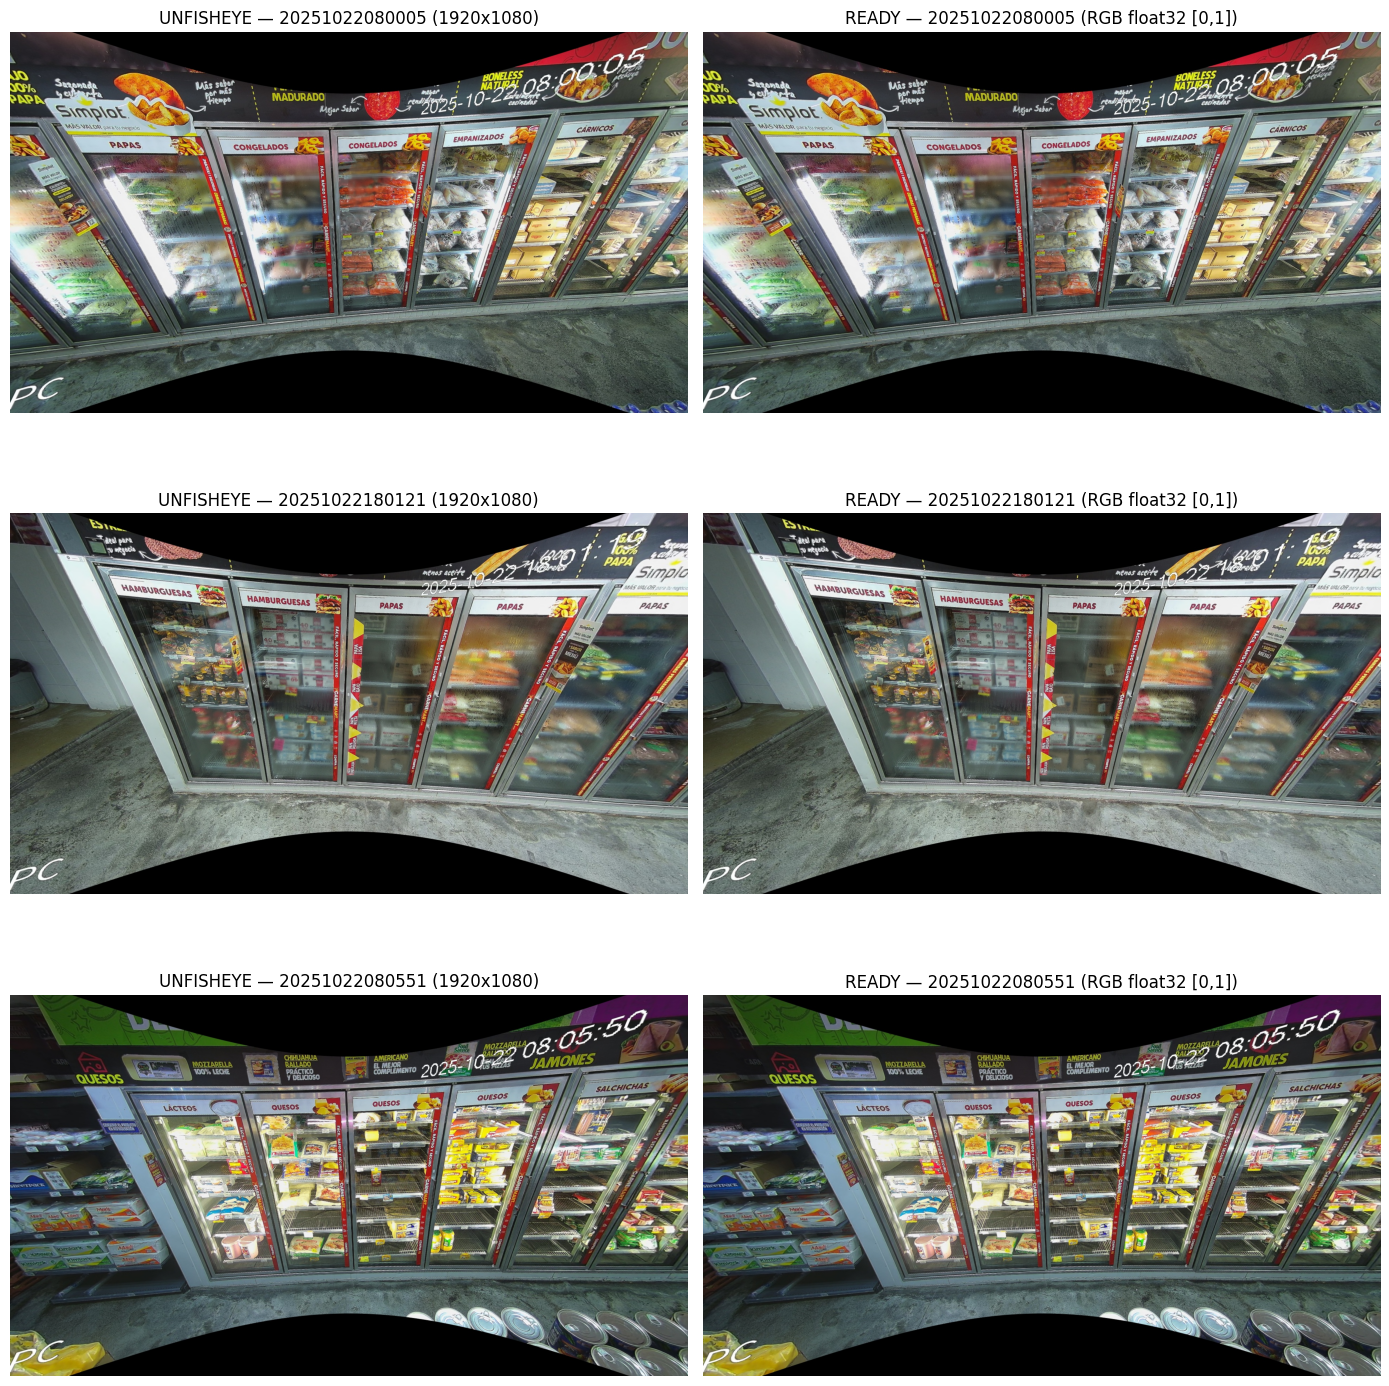

In [ ]:
def show_unfisheye_vs_ready(unfisheye_index, n=3, seed=42):
    random.seed(seed)
    keys = list(unfisheye_index.keys())
    picks = random.sample(keys, k=min(n, len(keys)))

    plt.figure(figsize=(14, 5 * len(picks)))

    for i, image_id in enumerate(picks, 1):
        path = unfisheye_index[image_id]
        img_unf_bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
        assert img_unf_bgr is not None, f"No se pudo leer: {path}"

        img_ready = preprocess_image(img_unf_bgr, force_resize=False)

        # Para mostrar unfisheye (BGR a RGB) en uint8
        img_unf_rgb = cv2.cvtColor(img_unf_bgr, cv2.COLOR_BGR2RGB)

        # UNFISHEYE
        plt.subplot(len(picks), 2, (i - 1) * 2 + 1)
        plt.imshow(img_unf_rgb)
        w, h = img_unf_rgb.shape[1], img_unf_rgb.shape[0]
        plt.title(f"UNFISHEYE — {image_id} ({w}x{h})")
        plt.axis("off")

        # READY (float [0,1])
        plt.subplot(len(picks), 2, (i - 1) * 2 + 2)
        plt.imshow(img_ready)
        plt.title(f"READY — {image_id} (RGB float32 [0,1])")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_unfisheye_vs_ready(unfisheye_index, n=3, seed=123)

En esta fase decidimos **no persistir en disco la representación “ready”**, ya que es una transformación ligera y totalmente determinista derivada de las imágenes en el espacio base post-*unfisheye* (p. ej., conversión de canales y normalización de intensidades a [0,1]). Guardarla en Drive duplicaría el dataset sin aportar información adicional y aumentaría la complejidad operativa (más artefactos, más riesgos de desalineación entre versiones). En su lugar, mantenemos como artefacto persistente la imagen post-*unfisheye* —que constituye la **fuente de verdad** del pipeline— y aplicamos “ready” en memoria al momento de visualizar, validar o alimentar modelos. Este enfoque también es consistente con el uso de frameworks como YOLO-Pose, que consumen imágenes estándar y aplican internamente sus propias transformaciones (p. ej., *letterbox*), por lo que almacenar tensores preprocesados no ofrece beneficios prácticos en nuestro flujo de trabajo.


# 6. Obtenemos anotaciones de cada imagen

Obtenemos puntos de cada puerta y manualmente los guardamos, para posteriormente generar un archivo JSON con estos datos, llamado all_annotations.json.

In [ ]:
path = data_path + 'unfisheye_data/20251022075804.jpg'
img_cv = cv2.imread(path)
original = img_cv.copy()
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# Convertir a base64 para HTML
pil_img = Image.fromarray(img_rgb)
buffered = BytesIO()
pil_img.save(buffered, format="PNG")
img_base64 = base64.b64encode(buffered.getvalue()).decode()

html_code = f"""
<div id="container" style="text-align: center;">
    <h2>🖱️ Haz clic en 4 esquinas del objeto</h2>
    <p id="status" style="font-size: 18px; font-weight: bold;">Puntos seleccionados: 0/4</p>
    <div style="position: relative; display: inline-block;">
        <canvas id="canvas" width="{img_rgb.shape[1]}" height="{img_rgb.shape[0]}"
                style="border: 3px solid #333; cursor: crosshair;"></canvas>
    </div>
    <br><br>
    <button onclick="resetPoints()" style="padding: 10px 20px; font-size: 16px; background: #ff6b6b; color: white; border: none; border-radius: 5px; cursor: pointer;">
        🔄 Resetear Puntos
    </button>
</div>

<script>
const canvas = document.getElementById('canvas');
const ctx = canvas.getContext('2d');
const img = new Image();
img.src = 'data:image/png;base64,{img_base64}';

let points = [];

img.onload = function() {{
    ctx.drawImage(img, 0, 0);
}};

canvas.addEventListener('click', function(e) {{
    if (points.length >= 4) {{
        alert('Ya tienes 4 puntos. Ejecuta la siguiente celda o resetea.');
        return;
    }}

    const rect = canvas.getBoundingClientRect();
    const x = Math.round(e.clientX - rect.left);
    const y = Math.round(e.clientY - rect.top);

    points.push([x, y]);

    // Redibujar imagen
    ctx.drawImage(img, 0, 0);

    // Dibujar todos los puntos
    points.forEach((p, i) => {{
        // Círculo verde
        ctx.beginPath();
        ctx.arc(p[0], p[1], 12, 0, 2 * Math.PI);
        ctx.fillStyle = 'lime';
        ctx.fill();
        ctx.strokeStyle = 'white';
        ctx.lineWidth = 3;
        ctx.stroke();

        // Número
        ctx.font = 'bold 24px Arial';
        ctx.fillStyle = 'red';
        ctx.strokeStyle = 'white';
        ctx.lineWidth = 4;
        ctx.strokeText(String(i+1), p[0] + 20, p[1] - 20);
        ctx.fillText(String(i+1), p[0] + 20, p[1] - 20);
    }});

    // Actualizar status
    document.getElementById('status').textContent = `Puntos seleccionados: ${{points.length}}/4`;

    // Guardar en Python
    google.colab.kernel.invokeFunction('notebook.get_points', [points], {{}});

    if (points.length === 4) {{
        document.getElementById('status').innerHTML = '✅ 4 puntos seleccionados! <span style="color: green;">Ejecuta la siguiente celda</span>';
    }}
}});

function resetPoints() {{
    points = [];
    ctx.drawImage(img, 0, 0);
    document.getElementById('status').textContent = 'Puntos seleccionados: 0/4';
    google.colab.kernel.invokeFunction('notebook.get_points', [[]], {{}});
}}
</script>
"""

puntos = []

def get_points(pts):
    global puntos
    puntos = pts
    return

output.register_callback('notebook.get_points', get_points)

display(HTML(html_code))

print("\n✅ Interfaz cargada. Haz clic en la imagen para seleccionar puntos.")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
puntos

[]

# 7. Normalización y consistencia de coordenadas

Ahora vamos a normalizar las anotaciones que hicimos para:

1.   Estabilidad numérica del entrenamiento
2.   Consistencia entre imágenes y futuras resoluciones
3.   Compatibilidad con pipelines de visión computacional y/o ML reales

In [ ]:
def _is_point(p):
    return (
        isinstance(p, (list, tuple))
        and len(p) == 2
        and isinstance(p[0], (int, float))
        and isinstance(p[1], (int, float))
    )

def _is_vertices(vs):
    return isinstance(vs, (list, tuple)) and len(vs) == 4 and all(_is_point(p) for p in vs)

def _require_wh(width, height):
    if width is None or height is None:
        raise ValueError("width/height are required for this conversion.")
    W = float(width); H = float(height)
    if W <= 0 or H <= 0:
        raise ValueError(f"Invalid width/height: {W}x{H}")
    return W, H

def _rounding_fn(rounding: str | None):
    if rounding is None:
        return None
    r = rounding.lower()
    if r == "round":
        return lambda x: int(round(x))
    if r == "floor":
        return lambda x: int(math.floor(x))
    if r == "ceil":
        return lambda x: int(math.ceil(x))
    raise ValueError("rounding must be one of: None, 'round', 'floor', 'ceil'")

def _validate_pixel_vertices(vs, W, H, allow_out_of_bounds=False):
    if allow_out_of_bounds:
        return
    for (x, y) in vs:
        if not (0 <= x <= W and 0 <= y <= H):
            raise ValueError(f"Pixel vertex out of bounds: {(x,y)} for W={W}, H={H}")

def _validate_normalized_vertices(vs, allow_out_of_bounds=False):
    if allow_out_of_bounds:
        return
    for (x, y) in vs:
        if not (0.0 <= x <= 1.0 and 0.0 <= y <= 1.0):
            raise ValueError(f"Normalized vertex out of bounds: {(x,y)}")


# ---------- Core converters ----------
def to_normalized(obj, width=None, height=None, *, allow_out_of_bounds=False):
    """
    Convert pixel -> normalized using (x/W, y/H).

    Supports:
      - list[annotation]
      - annotation dict: {"width","height","coordinate_space","doors":[...]}
      - door dict: {"vertices":[...]}
      - vertices: [[x,y],...]*4
    """
    o = deepcopy(obj)

    # Case: list of annotations
    if isinstance(o, list):
        return [to_normalized(a, allow_out_of_bounds=allow_out_of_bounds) for a in o]

    # Case: annotation dict
    if isinstance(o, dict) and "doors" in o and "width" in o and "height" in o:
        W, H = _require_wh(o["width"], o["height"])
        cs = o.get("coordinate_space", "pixel")
        if cs == "normalized":
            return o
        if cs != "pixel":
            raise ValueError(f"Unsupported coordinate_space: {cs}")

        for d in o["doors"]:
            vs = d.get("vertices")
            if not _is_vertices(vs):
                raise ValueError(f"Invalid vertices in door {d.get('door_id')}: {vs}")
            _validate_pixel_vertices(vs, W, H, allow_out_of_bounds=allow_out_of_bounds)
            d["vertices"] = [[p[0] / W, p[1] / H] for p in vs]

        o["coordinate_space"] = "normalized"
        return o

    # Case: door dict
    if isinstance(o, dict) and "vertices" in o:
        W, H = _require_wh(width, height)
        vs = o["vertices"]
        if not _is_vertices(vs):
            raise ValueError(f"Invalid vertices: {vs}")
        _validate_pixel_vertices(vs, W, H, allow_out_of_bounds=allow_out_of_bounds)
        o["vertices"] = [[p[0] / W, p[1] / H] for p in vs]
        return o

    # Case: vertices
    if _is_vertices(o):
        W, H = _require_wh(width, height)
        _validate_pixel_vertices(o, W, H, allow_out_of_bounds=allow_out_of_bounds)
        return [[p[0] / W, p[1] / H] for p in o]

    raise TypeError("Unsupported input. Provide list[annotation], annotation dict, door dict, or 4-vertex list.")


def to_pixel(obj, width=None, height=None, *, rounding="round", allow_out_of_bounds=False):
    """
    Convert normalized -> pixel using (x*W, y*H).
    rounding: 'round' | 'floor' | 'ceil' | None (None returns floats)

    Supports same shapes as to_normalized.
    """
    o = deepcopy(obj)
    rf = _rounding_fn(rounding)

    # Case: list of annotations
    if isinstance(o, list):
        return [to_pixel(a, rounding=rounding, allow_out_of_bounds=allow_out_of_bounds) for a in o]

    # Case: annotation dict
    if isinstance(o, dict) and "doors" in o and "width" in o and "height" in o:
        W, H = _require_wh(o["width"], o["height"])
        cs = o.get("coordinate_space", "pixel")
        if cs == "pixel":
            return o
        if cs != "normalized":
            raise ValueError(f"Unsupported coordinate_space: {cs}")

        for d in o["doors"]:
            vs = d.get("vertices")
            if not _is_vertices(vs):
                raise ValueError(f"Invalid vertices in door {d.get('door_id')}: {vs}")
            _validate_normalized_vertices(vs, allow_out_of_bounds=allow_out_of_bounds)

            px = []
            for (x, y) in vs:
                X = x * W
                Y = y * H
                px.append([rf(X) if rf else X, rf(Y) if rf else Y])

            d["vertices"] = px

        o["coordinate_space"] = "pixel"
        return o

    # Case: door dict
    if isinstance(o, dict) and "vertices" in o:
        W, H = _require_wh(width, height)
        vs = o["vertices"]
        if not _is_vertices(vs):
            raise ValueError(f"Invalid vertices: {vs}")
        _validate_normalized_vertices(vs, allow_out_of_bounds=allow_out_of_bounds)

        px = []
        for (x, y) in vs:
            X = x * W
            Y = y * H
            px.append([rf(X) if rf else X, rf(Y) if rf else Y])

        o["vertices"] = px
        return o

    # Case: vertices
    if _is_vertices(o):
        W, H = _require_wh(width, height)
        _validate_normalized_vertices(o, allow_out_of_bounds=allow_out_of_bounds)
        px = []
        for (x, y) in o:
            X = x * W
            Y = y * H
            px.append([rf(X) if rf else X, rf(Y) if rf else Y])
        return px

    raise TypeError("Unsupported input. Provide list[annotation], annotation dict, door dict, or 4-vertex list.")

In [ ]:
def test_round_trip_pixel_norm_pixel(annotations, *, max_abs_err=1):
    """
    Verifica que pixel -> normalized -> pixel (round) regrese a lo mismo (±1 por redondeo).
    """
    failures = []

    for ann in annotations:
        if ann.get("coordinate_space") != "pixel":
            raise ValueError(f"Expected pixel input, got {ann.get('coordinate_space')} in image_id={ann.get('image_id')}")

        W, H = ann["width"], ann["height"]
        ann_n = to_normalized(ann)
        ann_p = to_pixel(ann_n, rounding="round")

        for d0, d1 in zip(ann["doors"], ann_p["doors"]):
            v0 = d0["vertices"]
            v1 = d1["vertices"]
            for i, (p0, p1) in enumerate(zip(v0, v1)):
                dx = abs(p0[0] - p1[0])
                dy = abs(p0[1] - p1[1])
                if dx > max_abs_err or dy > max_abs_err:
                    failures.append({
                        "image_id": ann["image_id"],
                        "door_id": d0.get("door_id"),
                        "vertex_idx": i,
                        "orig": p0,
                        "back": p1,
                        "dx": dx,
                        "dy": dy,
                        "W": W,
                        "H": H
                    })

    return failures

In [ ]:
ANN_PATH = data_path + "annotations/all_annotations.json"

with open(ANN_PATH, "r", encoding="utf-8") as f:
    annotations = json.load(f)

print(f"Loaded {len(annotations)} annotation(s). First image_id={annotations[0]['image_id']}")

# 1) Convertir a normalized (lista completa)
annotations_norm = to_normalized(annotations)

# 2) Round-trip test
failures = test_round_trip_pixel_norm_pixel(annotations, max_abs_err=1)

if failures:
    print("❌ Round-trip failures:", len(failures))
    print("Example failure:", failures[0])
else:
    print("✅ Round-trip OK for all doors/vertices")

# 3) Guardar versión normalizada (útil para entrenamiento)
OUT_NORM = data_path + "annotations/all_annotations.normalized.json"
with open(OUT_NORM, "w", encoding="utf-8") as f:
    json.dump(annotations_norm, f, indent=2)

print("Saved:", OUT_NORM)

Loaded 1 annotation(s). First image_id=20251022075804
✅ Round-trip OK for all doors/vertices
Saved: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/annotations/all_annotations.normalized.json


# 8. Pruebas visuales del dataset

In [ ]:
ANN_PATH = data_path + "annotations/all_annotations.json"
OUT_DIR = Path(data_path)
QA_DIR = OUT_DIR / "qa"
QA_DIR.mkdir(parents=True, exist_ok=True)

UNFISHEYE_DIR = Path(data_path + "unfisheye_data")

# ---------- Load annotations ----------
def load_annotations(path: str | Path):
    path = Path(path)
    with path.open("r", encoding="utf-8") as f:
        data = json.load(f)

    if isinstance(data, dict) and "image_id" in data:
        return [data]
    if isinstance(data, dict):
        return list(data.values())
    if isinstance(data, list):
        return data
    raise TypeError("Formato no soportado en annotations file.")


def resolve_image_path_jpg(ann: dict, *, image_root: Path | None = None, fallback_dir: Path = UNFISHEYE_DIR) -> Path:
    """
    JPG-only:
      1) Si ann trae image_path, lo usa (relativo a image_root si aplica).
      2) Si no, usa fallback_dir / f"{image_id}.jpg"
    """
    image_root = image_root or Path(".")

    if ann.get("image_path"):
        p = Path(data_path + 'unfisheye_data/' + ann["image_path"])
        p = (image_root / p) if not p.is_absolute() else p
        if p.exists():
            return p
        raise FileNotFoundError(f"image_path no existe: {p}")

    image_id = ann.get("image_id")
    if not image_id:
        raise ValueError("annotation no tiene image_id ni image_path")

    p = fallback_dir / f"{image_id}.jpg"
    if not p.exists():
        raise FileNotFoundError(f"No existe JPG para image_id={image_id}: {p}")
    return p


def load_image_rgb(path: Path) -> np.ndarray:
    """
    Devuelve RGB uint8.
    """
    bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"No se pudo leer imagen: {path}")
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


def ensure_pixel_vertices(vertices, ann: dict) -> np.ndarray:
    """
    Si coordinate_space == normalized, convierte a pixel usando width/height del ann.
    Si ya está en pixel, devuelve tal cual.
    """
    cs = ann.get("coordinate_space", "pixel")
    W, H = float(ann["width"]), float(ann["height"])

    vs = np.array(vertices, dtype=np.float32)
    if vs.shape != (4, 2):
        raise ValueError(f"Vertices no tienen forma (4,2): got {vs.shape}")

    if cs == "pixel":
        return vs
    if cs == "normalized":
        vs[:, 0] = vs[:, 0] * W
        vs[:, 1] = vs[:, 1] * H
        return vs

    raise ValueError(f"coordinate_space no soportado: {cs}")


In [ ]:
def draw_points_and_polygon(
    img_rgb: np.ndarray,
    vertices_px: np.ndarray,
    *,
    door_id=None,
    is_valid=True,
    line_thickness=3,
    point_radius=6
) -> np.ndarray:
    """
    Dibuja polígono (TL->TR->BR->BL) + puntos numerados.
    Devuelve una copia (no muta el input).
    """
    out = img_rgb.copy()

    # Colores (RGB): verde si válido, naranja si inválido
    poly_color = (0, 255, 0) if is_valid else (255, 165, 0)

    pts = vertices_px.astype(np.int32).reshape(-1, 1, 2)
    cv2.polylines(out, [pts], isClosed=True, color=poly_color, thickness=line_thickness, lineType=cv2.LINE_AA)

    for i, (x, y) in enumerate(vertices_px):
        x_i, y_i = int(round(float(x))), int(round(float(y)))
        cv2.circle(out, (x_i, y_i), point_radius, (255, 255, 255), thickness=-1, lineType=cv2.LINE_AA)
        cv2.circle(out, (x_i, y_i), point_radius - 2, poly_color, thickness=-1, lineType=cv2.LINE_AA)

        # número 1..4 (orden)
        cv2.putText(out, str(i + 1), (x_i + 8, y_i - 8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 4, cv2.LINE_AA)
        cv2.putText(out, str(i + 1), (x_i + 8, y_i - 8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

    # etiqueta door
    label = f"door={door_id} valid={bool(is_valid)}"
    x0, y0 = int(pts[0, 0, 0]), int(pts[0, 0, 1])
    cv2.putText(out, label, (max(10, x0), max(30, y0 - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 4, cv2.LINE_AA)
    cv2.putText(out, label, (max(10, x0), max(30, y0 - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, poly_color, 2, cv2.LINE_AA)

    return out


def draw_annotation(img_rgb: np.ndarray, ann: dict) -> np.ndarray:
    """
    Dibuja todas las puertas encima.
    """
    out = img_rgb.copy()
    for d in ann.get("doors", []):
        vs_px = ensure_pixel_vertices(d["vertices"], ann)
        out = draw_points_and_polygon(
            out,
            vs_px,
            door_id=d.get("door_id"),
            is_valid=d.get("is_valid", True),
        )
    return out

Loaded 1 annotation(s)


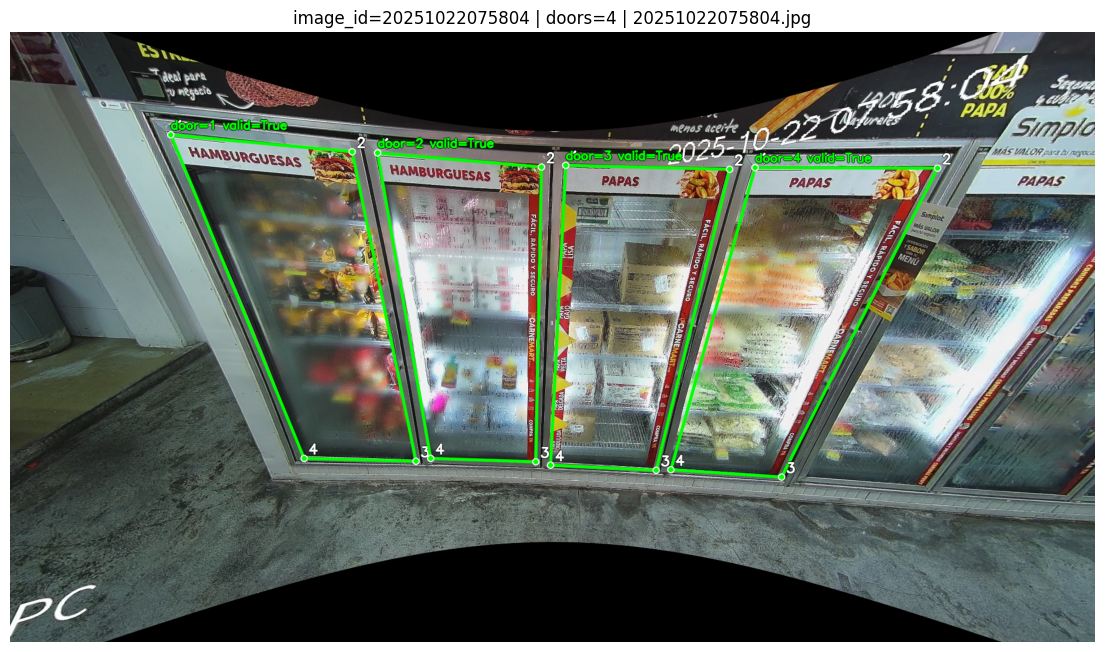

In [ ]:
annotations = load_annotations(ANN_PATH)
print(f"Loaded {len(annotations)} annotation(s)")

def show_random_samples(n=6, *, image_root=None, fallback_dir=UNFISHEYE_DIR, seed=0):
    random.seed(seed)
    picks = random.sample(annotations, k=min(n, len(annotations)))

    for ann in picks:
        img_path = resolve_image_path_jpg(ann, image_root=image_root, fallback_dir=fallback_dir)
        img = load_image_rgb(img_path)

        overlay = draw_annotation(img, ann)

        plt.figure(figsize=(14, 8))
        plt.title(f"image_id={ann.get('image_id')} | doors={len(ann.get('doors', []))} | {img_path.name}")
        plt.imshow(overlay)
        plt.axis("off")
        plt.show()

show_random_samples(n=6, seed=42)

## Exportar resultados

In [ ]:
def resize_keep_aspect(img_rgb, target_w=960):
    h, w = img_rgb.shape[:2]
    if w == target_w:
        return img_rgb
    scale = target_w / w
    new_h = int(round(h * scale))
    return cv2.resize(img_rgb, (target_w, new_h), interpolation=cv2.INTER_AREA)

def make_mosaic(images_rgb, cols=3, pad=12, bg=20):
    """
    Mosaico sin columnas vacías: si hay pocas imágenes, reduce cols automáticamente.
    """
    if not images_rgb:
        raise ValueError("No images for mosaic")

    # ✅ Evita espacio negro cuando N < cols
    cols = min(cols, len(images_rgb))

    max_w = max(im.shape[1] for im in images_rgb)

    # Normaliza todas a max_w manteniendo aspect ratio
    norm = []
    for im in images_rgb:
        if im.shape[1] != max_w:
            scale = max_w / im.shape[1]
            new_h = int(round(im.shape[0] * scale))
            im = cv2.resize(im, (max_w, new_h), interpolation=cv2.INTER_AREA)
        norm.append(im)

    rows = int(np.ceil(len(norm) / cols))

    # Altura por fila = max height de esa fila
    row_heights = []
    for r in range(rows):
        chunk = norm[r*cols:(r+1)*cols]
        row_heights.append(max(im.shape[0] for im in chunk))

    mosaic_h = sum(row_heights) + pad*(rows+1)
    mosaic_w = cols*max_w + pad*(cols+1)
    canvas = np.zeros((mosaic_h, mosaic_w, 3), dtype=np.uint8) + bg

    y = pad
    idx = 0
    for r in range(rows):
        x = pad
        rh = row_heights[r]
        for c in range(cols):
            if idx >= len(norm):
                break
            im = norm[idx]
            h, w = im.shape[:2]
            y0 = y + (rh - h)//2
            canvas[y0:y0+h, x:x+w] = im
            x += max_w + pad
            idx += 1
        y += rh + pad

    return canvas

def export_qa_mosaics(
    num_images=12, cols=3, target_w=960,
    *, image_root=None, fallback_dir=UNFISHEYE_DIR,
    out_dir=QA_DIR, seed=0
):
    random.seed(seed)
    picks = random.sample(annotations, k=min(num_images, len(annotations)))

    rendered = []
    used = 0

    for ann in picks:
        img_path = resolve_image_path_jpg(ann, image_root=image_root, fallback_dir=fallback_dir)
        img = load_image_rgb(img_path)
        overlay = draw_annotation(img, ann)
        overlay = resize_keep_aspect(overlay, target_w=target_w)
        rendered.append(overlay)
        used += 1

    mosaic = make_mosaic(rendered, cols=cols, pad=14)

    out_path = QA_DIR / f"qa_mosaic_{used}imgs_seed{seed}.png"
    cv2.imwrite(str(out_path), cv2.cvtColor(mosaic, cv2.COLOR_RGB2BGR))
    print("✅ saved:", out_path)
    return out_path

export_qa_mosaics(num_images=12, cols=3, seed=123)

✅ saved: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/qa/qa_mosaic_1imgs_seed123.png


PosixPath('/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/qa/qa_mosaic_1imgs_seed123.png')

# 9. Homografía y rectificación determinista

In [ ]:
def _ensure_pixel_vertices(vertices, ann):
    """
    Acepta vertices en pixel o normalized y devuelve pixel float32 (4,2).
    """
    vs = np.array(vertices, dtype=np.float32)
    if vs.shape != (4, 2):
        raise ValueError(f"Vertices deben ser (4,2). Got {vs.shape}")

    cs = ann.get("coordinate_space", "pixel")
    if cs == "pixel":
        return vs

    if cs == "normalized":
        W, H = float(ann["width"]), float(ann["height"])
        vs[:, 0] *= W
        vs[:, 1] *= H
        return vs

    raise ValueError(f"coordinate_space no soportado: {cs}")


def _order_points_tl_tr_br_bl(pts):
    """
    pts: (N,2) float
    retorna (4,2): TL, TR, BR, BL
    """
    pts = np.array(pts, dtype=np.float32)
    if pts.ndim != 2 or pts.shape[1] != 2:
        raise ValueError(f"pts debe ser (N,2). Got {pts.shape}")

    s = pts[:, 0] + pts[:, 1]          # x + y
    d = pts[:, 1] - pts[:, 0]          # y - x

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(d)]
    bl = pts[np.argmax(d)]

    return np.stack([tl, tr, br, bl], axis=0).astype(np.float32)


def shelf_quad_from_annotation(ann, *, max_doors=4, only_valid=True):
    """
    Devuelve 4 puntos (TL,TR,BR,BL) del anaquel a partir de los vertices de puertas.
    - Usa como máximo max_doors puertas, incluso si ann trae más.
    - Si only_valid=True, ignora puertas con is_valid=False.
    """
    doors = ann.get("doors", [])
    if only_valid:
        doors = [d for d in doors if d.get("is_valid", True)]

    if not doors:
        raise ValueError(f"No hay puertas válidas en image_id={ann.get('image_id')}")

    # ✅ asegurar máximo 4 puertas
    # Preferencia: ordenar por door_id si es numérico; si no, usa orden original.
    def door_key(d):
        v = d.get("door_id")
        try:
            return int(v)
        except Exception:
            return 10**9  # al final si no es numérico

    doors_sorted = sorted(doors, key=door_key)
    doors_use = doors_sorted[:max_doors]

    all_pts = []
    for d in doors_use:
        vs_px = _ensure_pixel_vertices(d["vertices"], ann)  # (4,2)
        all_pts.append(vs_px)

    all_pts = np.concatenate(all_pts, axis=0)  # (4*k,2)
    quad = _order_points_tl_tr_br_bl(all_pts)
    return quad

/tmp/ipython-input-2713470672.py:71: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2713470672.py:71: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


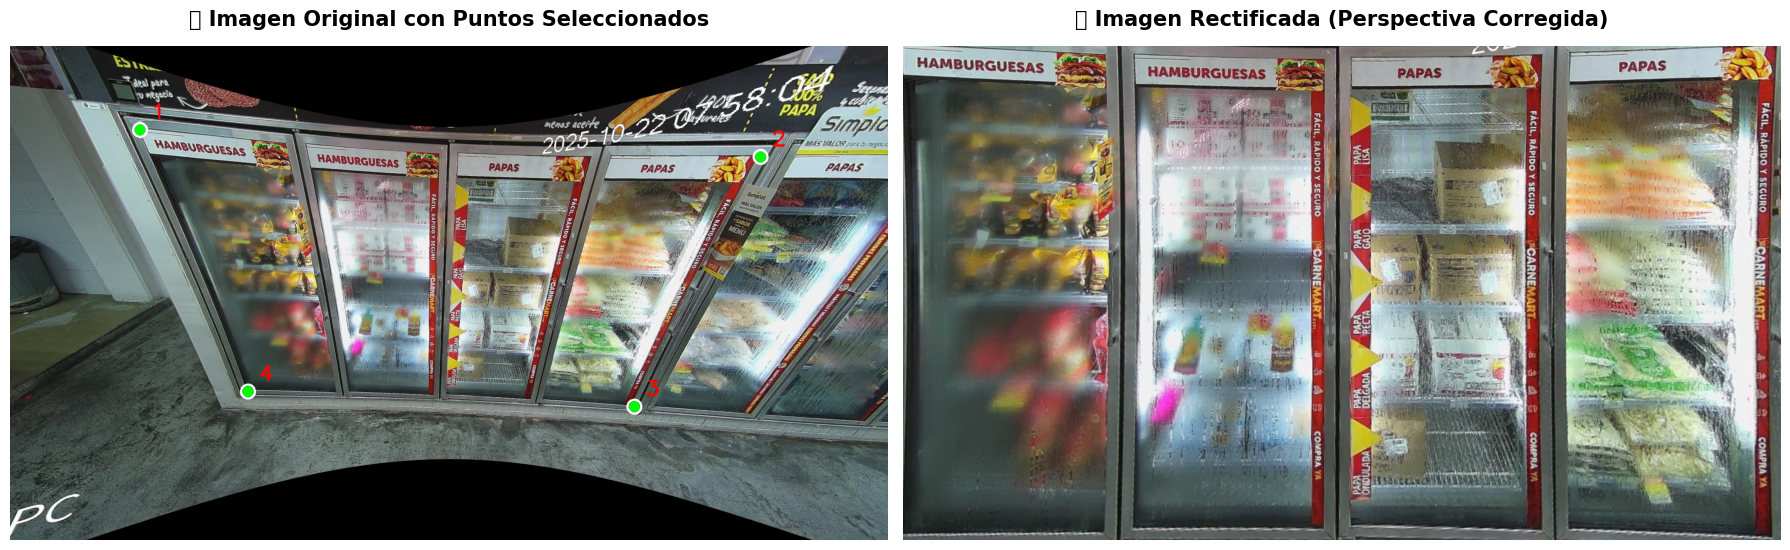

✅ ¡Rectificación completada exitosamente!

📍 Coordenadas de los puntos (ordenados automáticamente):
------------------------------------------------------------
   1. Arriba-Izquierda   : x= 284, y= 183
   2. Arriba-Derecha    : x=1641, y= 242
   3. Abajo-Derecha     : x=1365, y= 788
   4. Abajo-Izquierda   : x= 520, y= 755
------------------------------------------------------------
📐 Dimensiones de salida: 1920 × 1080 píxeles

💡 Tip: Puedes cambiar W y H en el código para ajustar el tamaño de salida
✅ Imagen rectificada guardada en: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/rectified/20251022075804_rect_1920x1080.png


In [ ]:
ANN_PATH = data_path + "annotations/all_annotations.json"
IMAGE_ID = "20251022075804"

def load_annotations_any(path: str | Path):
    path = Path(path)
    with path.open("r", encoding="utf-8") as f:
        data = json.load(f)

    # Caso: un solo annotation dict
    if isinstance(data, dict) and "image_id" in data and "doors" in data:
        return [data]

    # Caso: dict indexado por image_id
    if isinstance(data, dict):
        return list(data.values())

    # Caso: lista
    if isinstance(data, list):
        return data

    raise TypeError("Formato no soportado en all_annotations.json")


def build_ann_index(annotations: list[dict]):
    idx = {}
    for a in annotations:
        image_id = a.get("image_id")
        if not image_id:
            raise ValueError("Encontré una anotación sin image_id")
        idx[str(image_id)] = a
    return idx


def get_ann_by_image_id(all_annotations_path: str | Path, image_id: str):
    annotations = load_annotations_any(all_annotations_path)
    idx = build_ann_index(annotations)
    if str(image_id) not in idx:
        raise KeyError(f"image_id no encontrado: {image_id}. Disponibles: {list(idx.keys())[:5]} ...")
    return idx[str(image_id)]

ann = get_ann_by_image_id(ANN_PATH, IMAGE_ID)

pts1 = shelf_quad_from_annotation(ann, max_doors=4, only_valid=True)  # (4,2) TL,TR,BR,BL
W, H = 1920, 1080
pts2 = np.float32([[0, 0], [W, 0], [W, H], [0, H]])
M = cv2.getPerspectiveTransform(pts1, pts2)
rectificada = cv2.warpPerspective(original, M, (W, H))

# Imagen con puntos marcados
img_con_puntos = original.copy()
for i, pt in enumerate(pts1):
    x, y = int(pt[0]), int(pt[1])
    cv2.circle(img_con_puntos, (x, y), 12, (0, 255, 0), -1)
    cv2.circle(img_con_puntos, (x, y), 15, (255, 255, 255), 3)
    cv2.putText(img_con_puntos, str(i+1), (x+25, y-25),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 4)

# Mostrar resultados lado a lado
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

axes[0].imshow(cv2.cvtColor(img_con_puntos, cv2.COLOR_BGR2RGB))
axes[0].set_title("📷 Imagen Original con Puntos Seleccionados",
                  fontsize=15, weight='bold', pad=15)
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(rectificada, cv2.COLOR_BGR2RGB))
axes[1].set_title("✨ Imagen Rectificada (Perspectiva Corregida)",
                  fontsize=15, weight='bold', pad=15)
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✅ ¡Rectificación completada exitosamente!\n")
print("📍 Coordenadas de los puntos (ordenados automáticamente):")
print("-" * 60)
nombres = ['Arriba-Izquierda  ', 'Arriba-Derecha   ',
            'Abajo-Derecha    ', 'Abajo-Izquierda  ']
for i, pt in enumerate(pts1):
    print(f"   {i+1}. {nombres[i]} : x={int(pt[0]):4d}, y={int(pt[1]):4d}")
print("-" * 60)
print(f"📐 Dimensiones de salida: {W} × {H} píxeles")

RECT_OUT_DIR = Path(data_path + "rectified")
RECT_OUT_DIR.mkdir(parents=True, exist_ok=True)
out_path = RECT_OUT_DIR / f"{IMAGE_ID}_rect_{W}x{H}.png"
ok = cv2.imwrite(str(out_path), rectificada)  # rectificada es BGR en tu código actual
if not ok:
    raise RuntimeError(f"No se pudo guardar: {out_path}")
print("✅ Imagen rectificada guardada en:", out_path)


# 10. Conclusiones

En esta fase se logró transformar las imágenes originales en una representación geométrica estructurada, corrigiendo distorsión (undistort/unfisheye), aplicando homografía y generando anotaciones consistentes en formato JSON. Esto permitió reducir la variabilidad espacial entre imágenes y establecer una base estandarizada para el procesamiento automático de anaqueles fríos.

La ingeniería de características realizada permitió pasar de datos crudos (imágenes RGB) a una representación más compacta y significativa basada en vértices, puertas y relaciones geométricas, facilitando la preparación del sistema para etapas posteriores de automatización.

Como próximos pasos, se plantea automatizar la detección de vértices mediante un modelo de visión computacional, eliminando la selección manual de puntos. Asimismo, se integrará el pipeline completo para que el sistema procese cada imagen de forma autónoma y genere el JSON final requerido por el cliente. Finalmente, se realizarán pruebas de robustez ante variaciones de iluminación, inclinación y vibración para asegurar la capacidad de generalización del modelo en escenarios reales.